# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from farasa.stemmer import FarasaStemmer
import gensim
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import helper

# Read and Clean 

In [2]:
df_train = pd.read_csv(r"data/ArSarcasm_train.csv")
df_test = pd.read_csv(r"data/ArSarcasm_test.csv")

In [3]:
stemmer =  FarasaStemmer(interactive=True)

[2021-06-25 03:02:40,840 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [4]:
df_train['cleaned_tweet'] = df_train['tweet'].apply(helper.clean_tweet)
df_test['cleaned_tweet'] = df_test['tweet'].apply(helper.clean_tweet)

In [5]:
df_train['cleaned_tweet'] = df_train['cleaned_tweet'].apply(lambda x: stemmer.stem(x))
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].apply(lambda x: stemmer.stem(x))

# Remove stopwords

In [6]:
df_train["cleaned_tweet"] = df_train["cleaned_tweet"].apply(helper.remove_stopWords)
df_test["cleaned_tweet"] = df_test["cleaned_tweet"].apply(helper.remove_stopWords)

# Build our Vocab List

In [7]:
vocab = []
for tw in df_train['cleaned_tweet']:
    for word in tw.split():
        if word not in vocab:
            vocab.append(word)

vocab = sorted(vocab)

In [8]:
print(len(vocab))

17355


# Prepare Data to Train

In [9]:
train_data = df_train[['sarcasm', 'cleaned_tweet']]
test_data = df_test[['sarcasm', 'cleaned_tweet']]

In [10]:
train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)

<ipython-input-10-8cb7745a2a45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
<ipython-input-10-8cb7745a2a45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)


In [11]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
X_train = train_data['cleaned_tweet']
X_test = test_data['cleaned_tweet']
y_train = train_data['sarcasm'].tolist()
y_test = test_data['sarcasm'].tolist()

print('Size of train data: {}'.format(len(X_train)))
print('Size of test data: {}'.format(len(X_test)))
print('Size of train labels: {}'.format(len(y_train)))
print('Size of test labels: {}'.format(len(y_test)))

Size of train data: 10163
Size of test data: 2980
Size of train labels: 10163
Size of test labels: 2980


<ipython-input-11-9b13ab82f2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(inplace=True)
<ipython-input-11-9b13ab82f2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(inplace=True)


## Embedding Visualization

### Bag of Word (BOW)

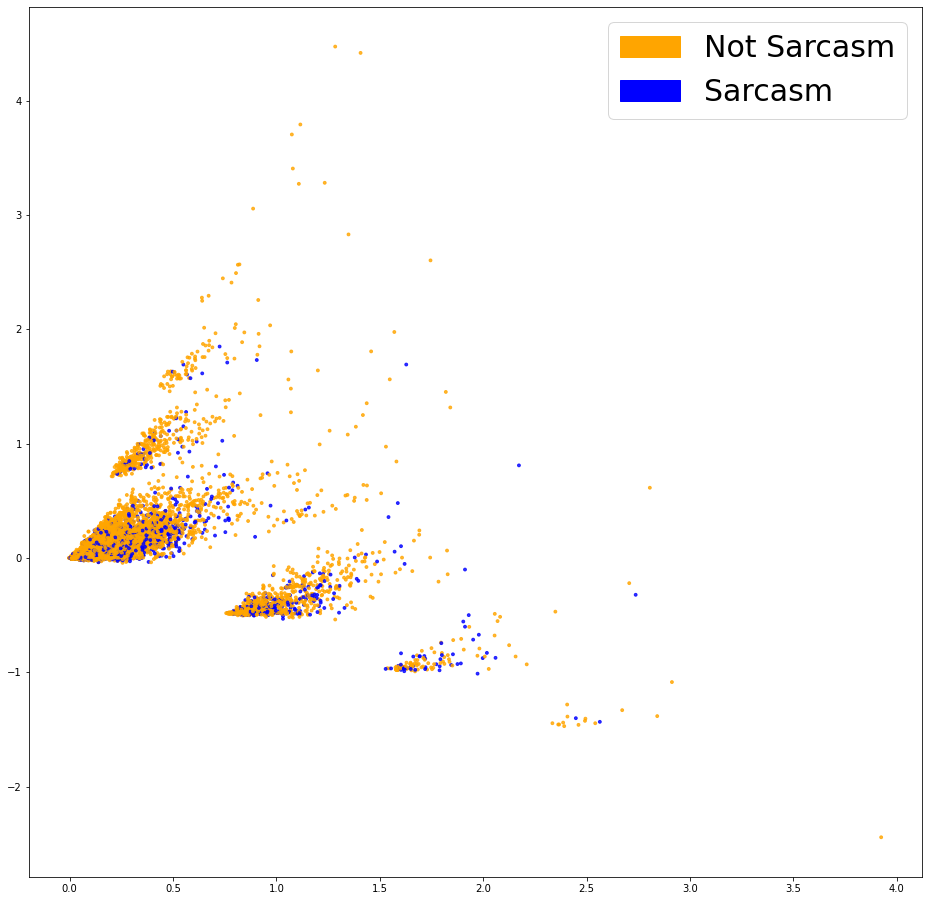

In [12]:
X_train_bow_emb, count_vectorizer = helper.bow_emb(X_train)
X_test_bow_emb = count_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_bow_emb, y_train)
plt.show()

### TF-IDF

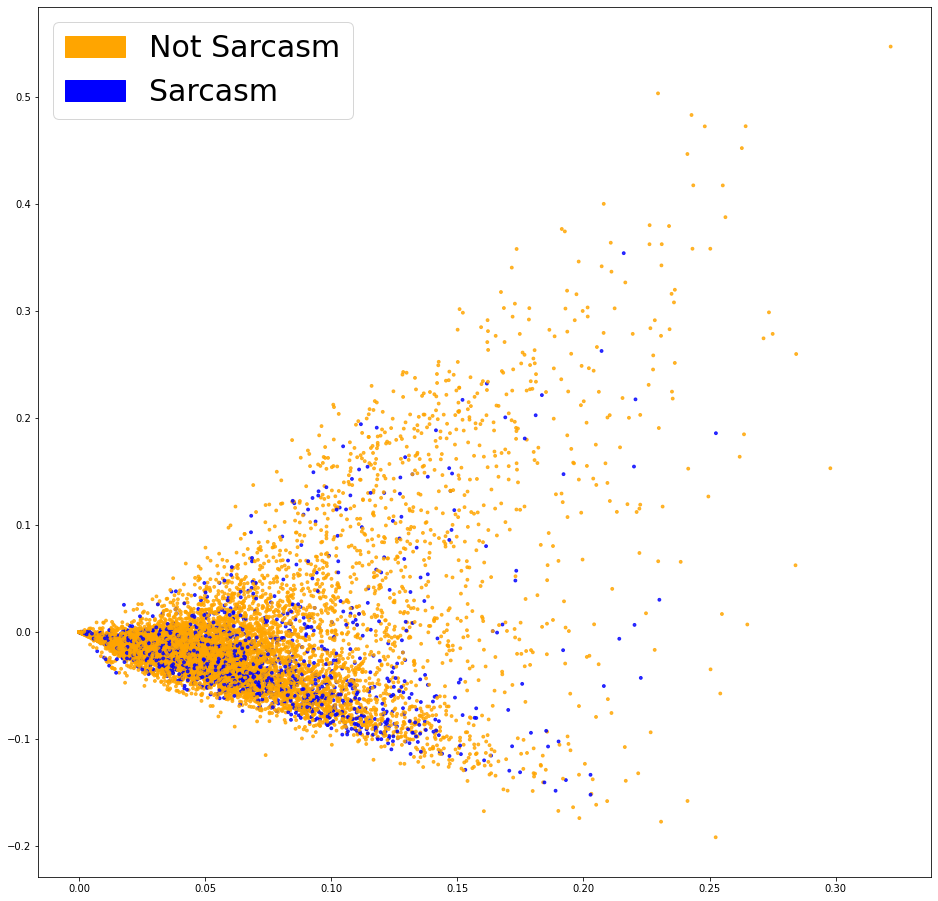

In [13]:
X_train_tfidf_emb, tfidf_vectorizer = helper.tfidf(X_train)
X_test_tfidf_emb = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_tfidf_emb, y_train)
plt.show()

### Pre-trained Word2Vec Model

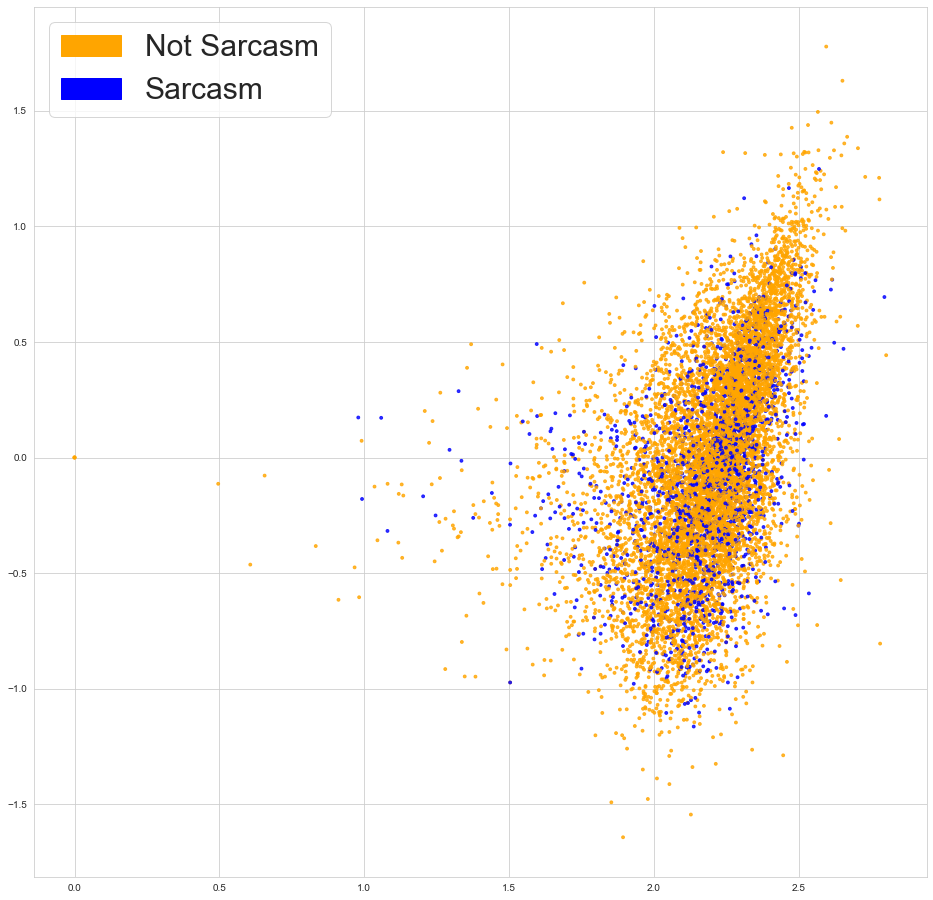

In [24]:
word2vec_path = "sg_100.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')   

tokenizer = RegexpTokenizer(r'\w+')
X_train_tokens = train_data['cleaned_tweet'].apply(tokenizer.tokenize)
X_test_tokens = test_data['cleaned_tweet'].apply(tokenizer.tokenize)

train_embeddings = helper.get_word2vec_embeddings(model, X_train_tokens)
test_embeddings = helper.get_word2vec_embeddings(model, X_test_tokens)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(train_embeddings, y_train)
plt.show()

## Train Models

### Logistic Regression with BOW

The f1 score for the testing data: 0.4486842105263158
The precision score for the testing data: 0.48575498575498577
The recall score for the testing data: 0.41687041564792177
The accuracy score for the testing data: 0.7187919463087248


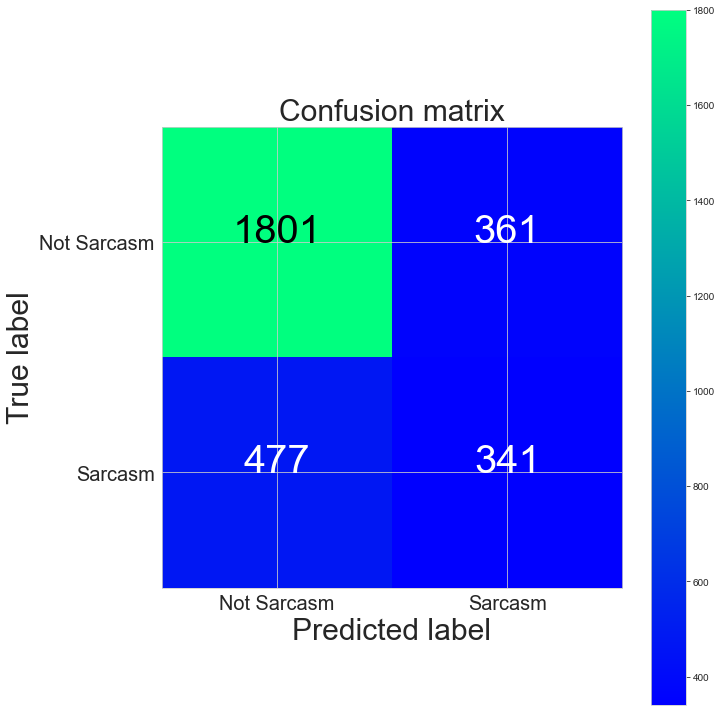

In [18]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


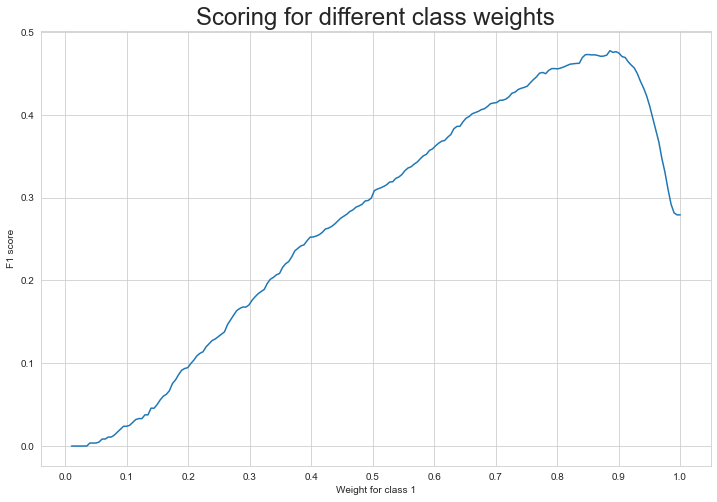

In [19]:
lr_bow = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_bow, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.4962243797195254
The precision score for the testing data: 0.444015444015444
The recall score for the testing data: 0.5623471882640587
The accuracy score for the testing data: 0.6865771812080537


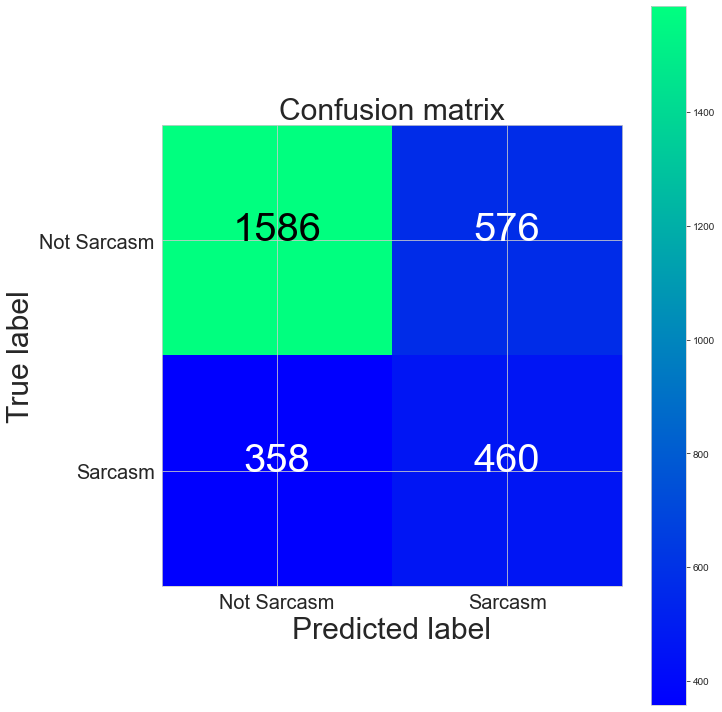

In [20]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight=gridsearch.best_params_['class_weight'])
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

In [67]:
importance = helper.get_most_important_features(count_vectorizer, lr_bow, 10)

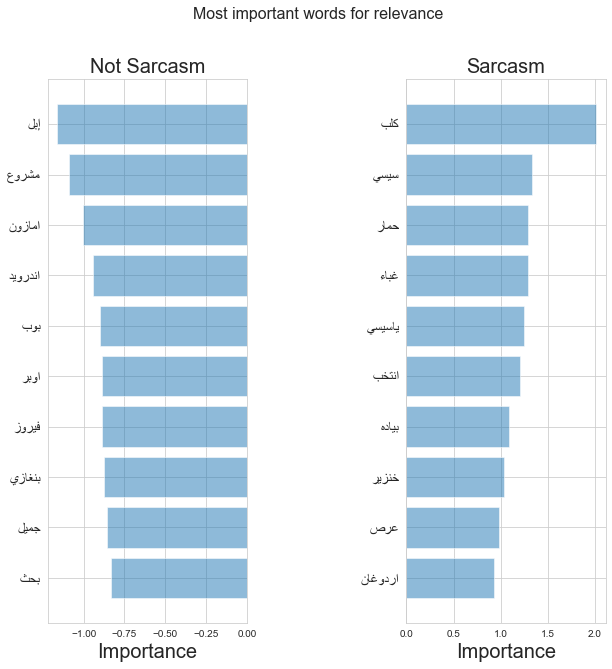

In [68]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Logistic Regression with TF-IDF

The f1 score for the testing data: 0.47113163972286376
The precision score for the testing data: 0.44638949671772427
The recall score for the testing data: 0.49877750611246946
The accuracy score for the testing data: 0.6926174496644295


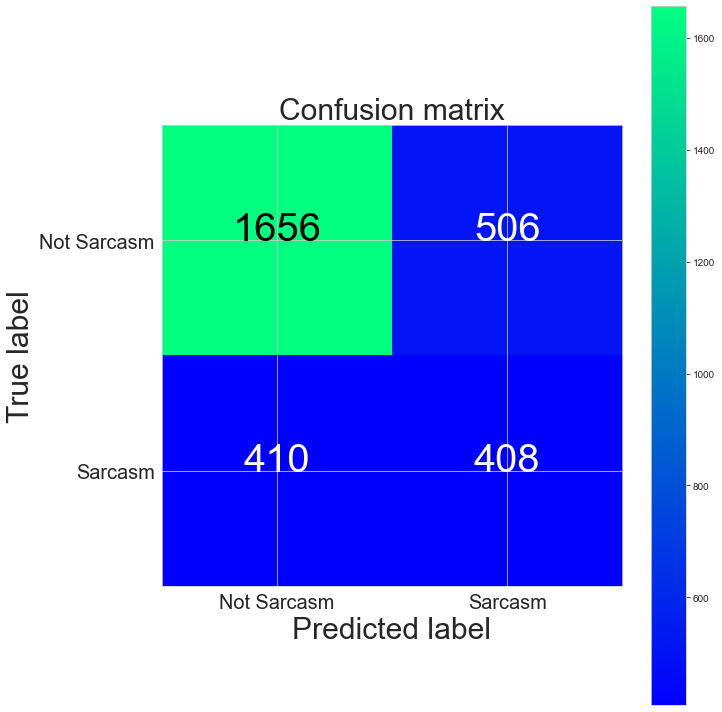

In [21]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


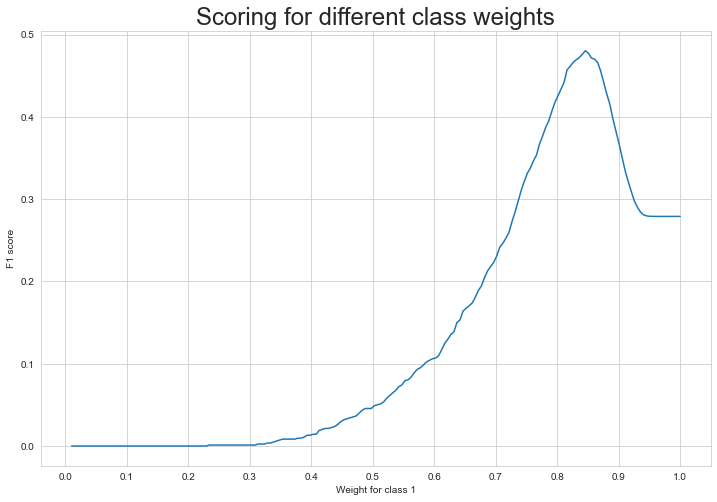

In [22]:
lr_tfidf = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_tfidf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.4741951967296883
The precision score for the testing data: 0.4073748902546093
The recall score for the testing data: 0.5672371638141809
The accuracy score for the testing data: 0.6546979865771813


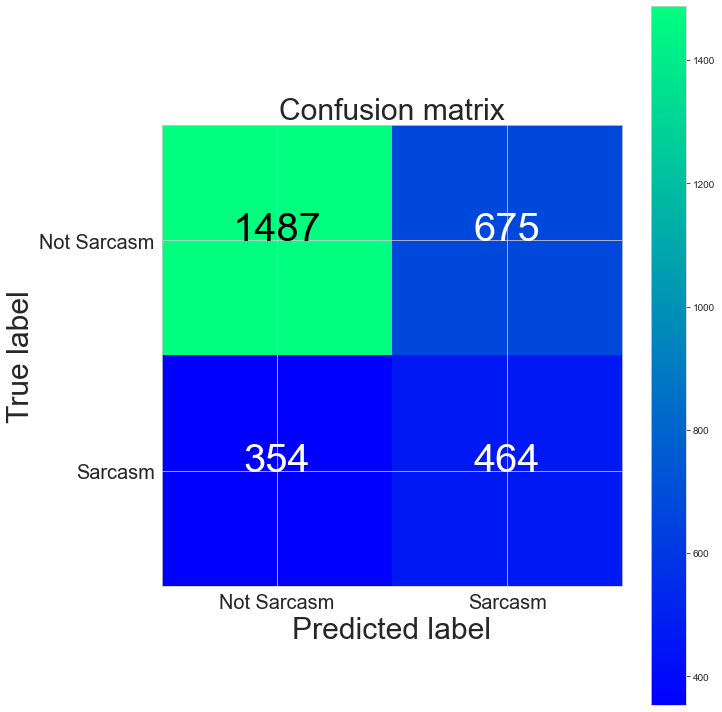

In [23]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight = gridsearch.best_params_['class_weight'])
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

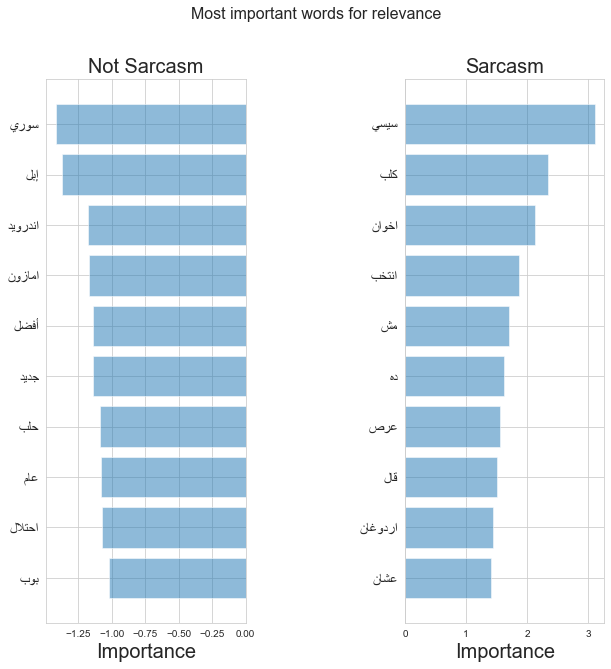

In [75]:
importance = helper.get_most_important_features(tfidf_vectorizer, lr_tfidf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Logistic Regression with W2V Pre-trained Embeddings

The f1 score for the testing data: 0.510909090909091
The precision score for the testing data: 0.40665701881331406
The recall score for the testing data: 0.687041564792176
The accuracy score for the testing data: 0.6389261744966444


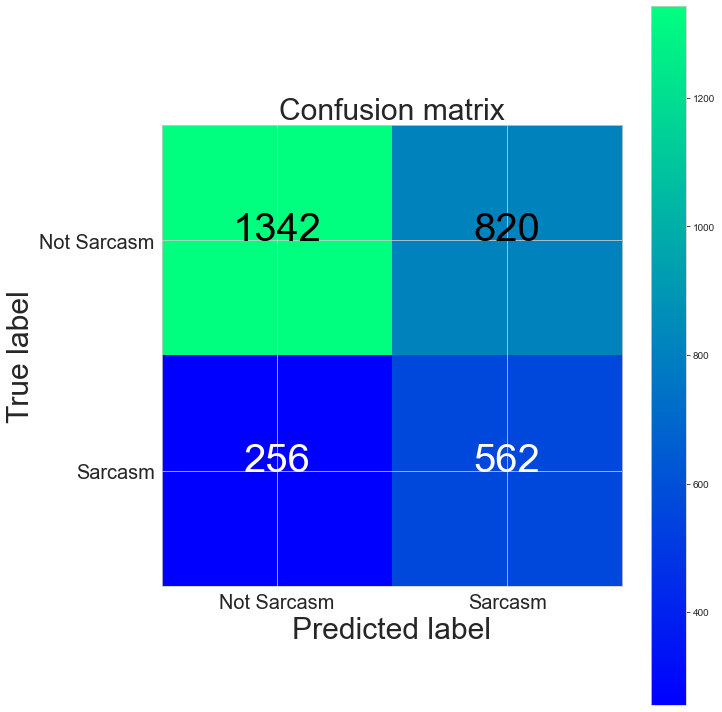

In [25]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


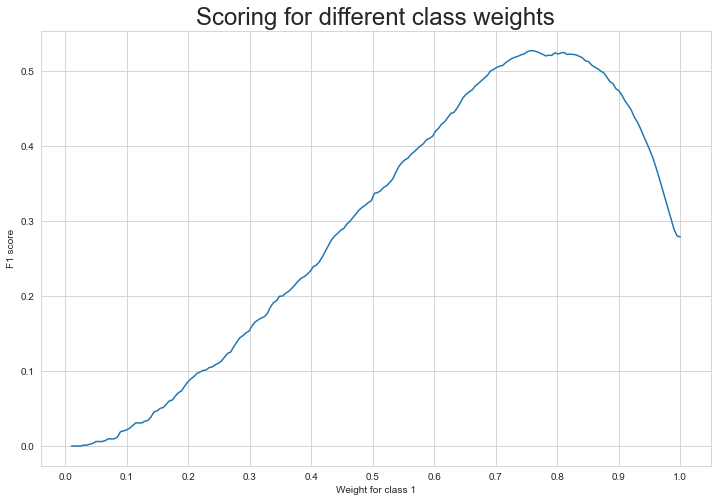

In [26]:
lr_w2v = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_tfidf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.47403314917127076
The precision score for the testing data: 0.4324596774193548
The recall score for the testing data: 0.5244498777506112
The accuracy score for the testing data: 0.6805369127516778


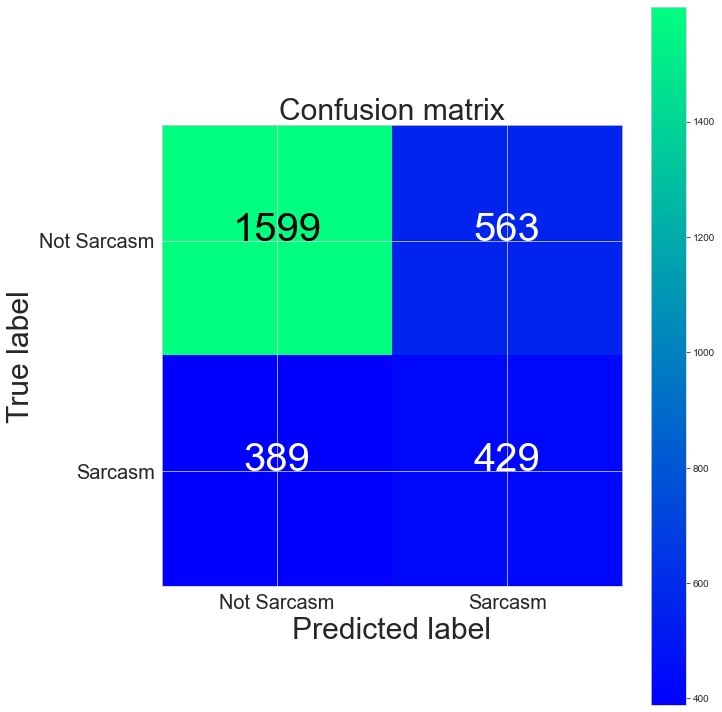

In [27]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight=gridsearch.best_params_['class_weight'])
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with BOW

The f1 score for the testing data: 0.26397800183318054
The precision score for the testing data: 0.5274725274725275
The recall score for the testing data: 0.17603911980440098
The accuracy score for the testing data: 0.7305369127516779


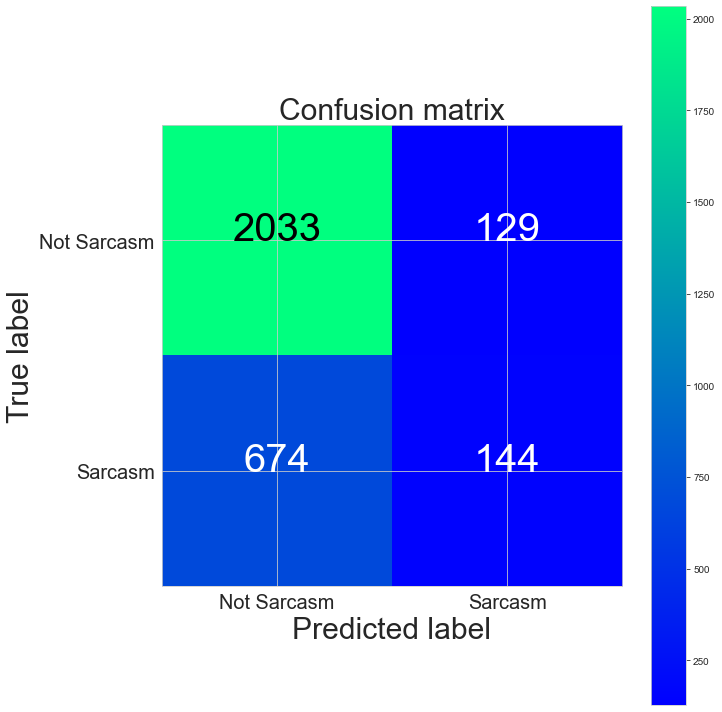

In [28]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_bow_emb, y_train)
pred_test = svm.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


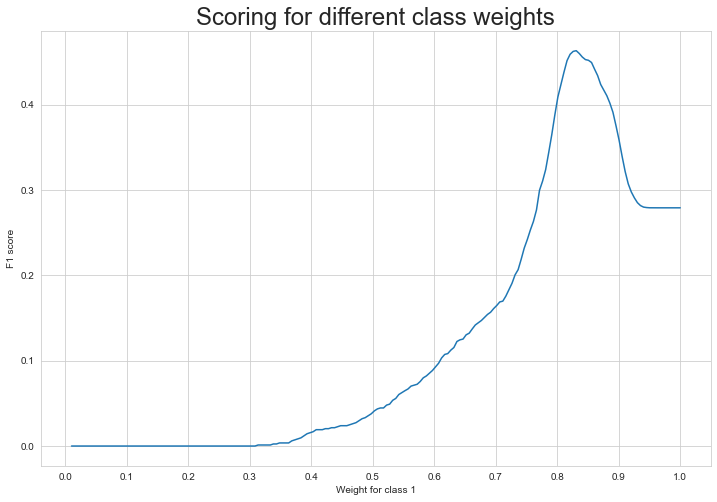

In [29]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.493771234428086
The precision score for the testing data: 0.459915611814346
The recall score for the testing data: 0.5330073349633252
The accuracy score for the testing data: 0.7


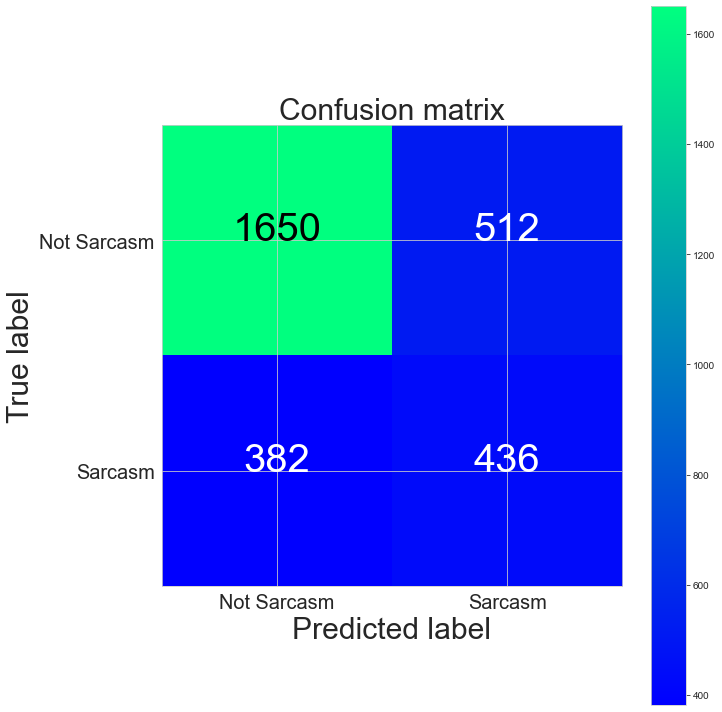

In [30]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = svm.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with TF-IDF

The f1 score for the testing data: 0.28493150684931506
The precision score for the testing data: 0.5631768953068592
The recall score for the testing data: 0.19070904645476772
The accuracy score for the testing data: 0.737248322147651


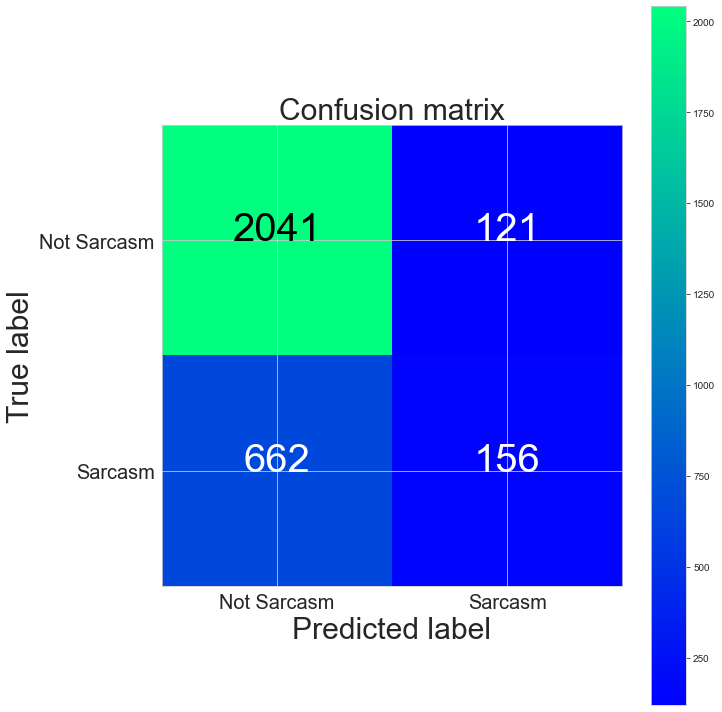

In [31]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_tfidf_emb, y_train)
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


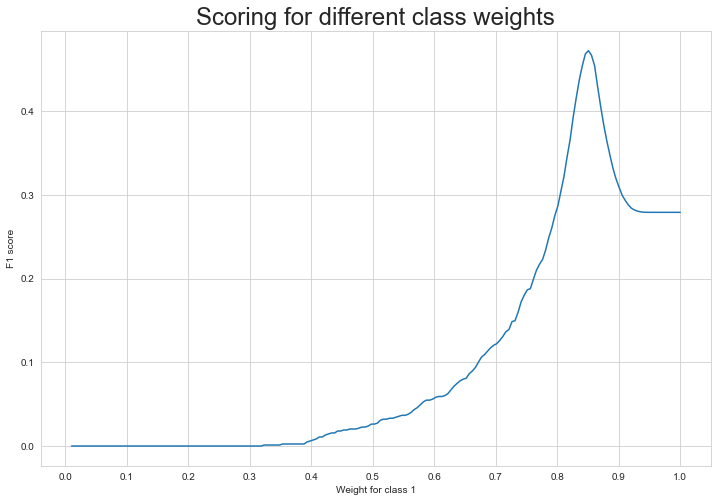

In [32]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.4697508896797153
The precision score for the testing data: 0.402088772845953
The recall score for the testing data: 0.5647921760391198
The accuracy score for the testing data: 0.65


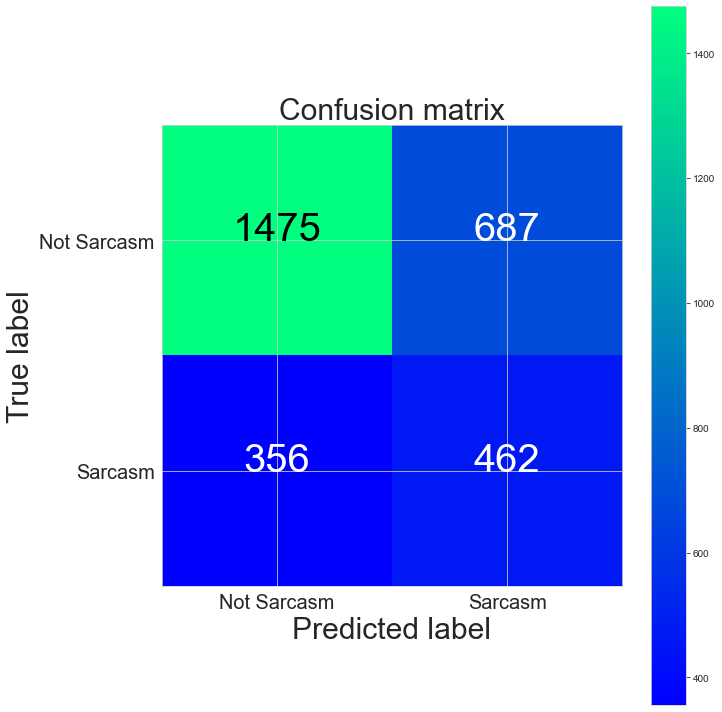

In [33]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with W2V Pre-trained Embeddings

The f1 score for the testing data: 0.5781563126252505
The precision score for the testing data: 0.4898132427843803
The recall score for the testing data: 0.7053789731051344
The accuracy score for the testing data: 0.7174496644295302


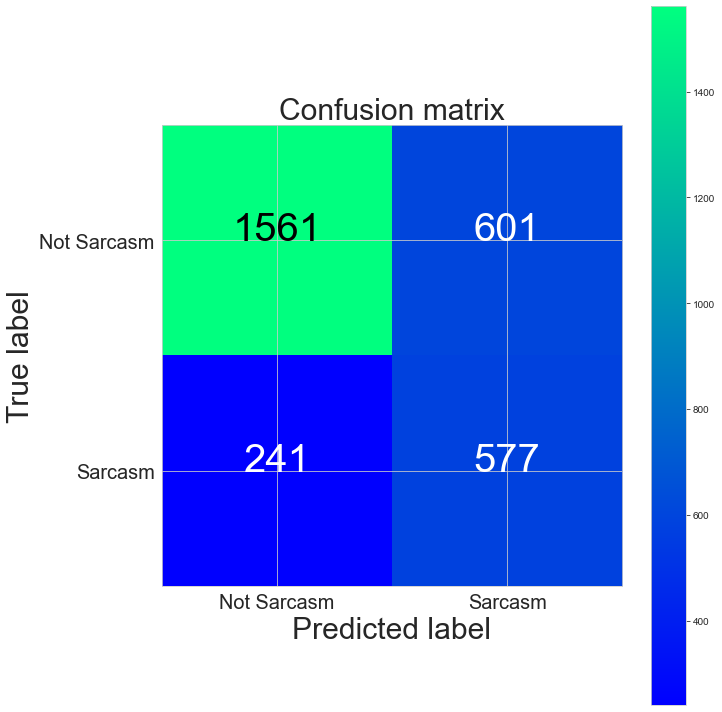

In [34]:
svm = SVC(class_weight='balanced')
svm.fit(train_embeddings, y_train)
pred_test = svm.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


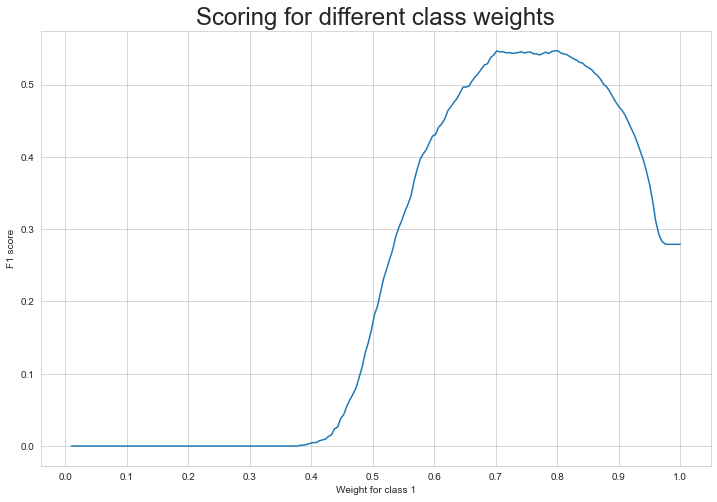

In [35]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the testing data: 0.5755627009646302
The precision score for the testing data: 0.5124045801526718
The recall score for the testing data: 0.656479217603912
The accuracy score for the testing data: 0.7342281879194631


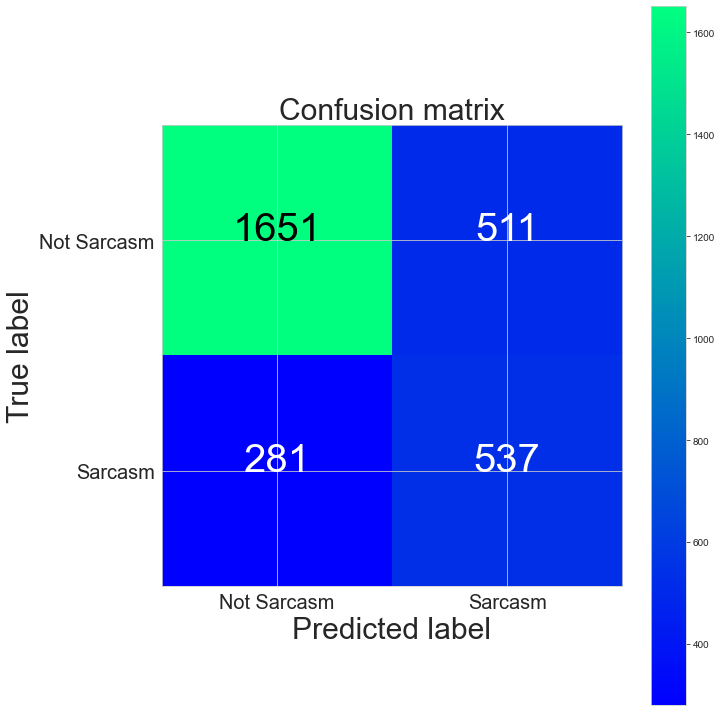

In [36]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = svm.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

In [ ]:
svm.

In [42]:
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
weights = np.linspace(0.0,0.99,50)
# evaluate a decision tree for each depth
for i in weights:
    # configure the model
    svm = SVC(class_weight={0:i, 1:1.0-i})
    # fit model on the training dataset
    svm.fit(train_embeddings, y_train)
    # evaluate on the train dataset
    train_yhat = svm.predict(train_embeddings)
    train_acc = f1_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = svm.predict(test_embeddings)
    test_acc = f1_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

>0, train: 0.279, test: 0.431
>0, train: 0.279, test: 0.431
>0, train: 0.330, test: 0.471
>0, train: 0.415, test: 0.521
>0, train: 0.463, test: 0.538
>0, train: 0.499, test: 0.560
>0, train: 0.530, test: 0.570
>0, train: 0.554, test: 0.573
>0, train: 0.575, test: 0.579
>0, train: 0.584, test: 0.574
>0, train: 0.594, test: 0.574
>0, train: 0.606, test: 0.564
>0, train: 0.601, test: 0.553
>0, train: 0.596, test: 0.545
>0, train: 0.594, test: 0.541
>0, train: 0.594, test: 0.528
>0, train: 0.582, test: 0.507
>0, train: 0.569, test: 0.493
>0, train: 0.551, test: 0.468
>0, train: 0.528, test: 0.429
>0, train: 0.500, test: 0.393
>0, train: 0.460, test: 0.361
>0, train: 0.419, test: 0.326
>0, train: 0.355, test: 0.262
>0, train: 0.287, test: 0.198
>0, train: 0.222, test: 0.145
>0, train: 0.138, test: 0.080
>0, train: 0.077, test: 0.019
>0, train: 0.037, test: 0.002
>0, train: 0.017, test: 0.000
>0, train: 0.008, test: 0.000
>0, train: 0.004, test: 0.000
>0, train: 0.000, test: 0.000
>0, train:

NameError: name 'pyplot' is not defined

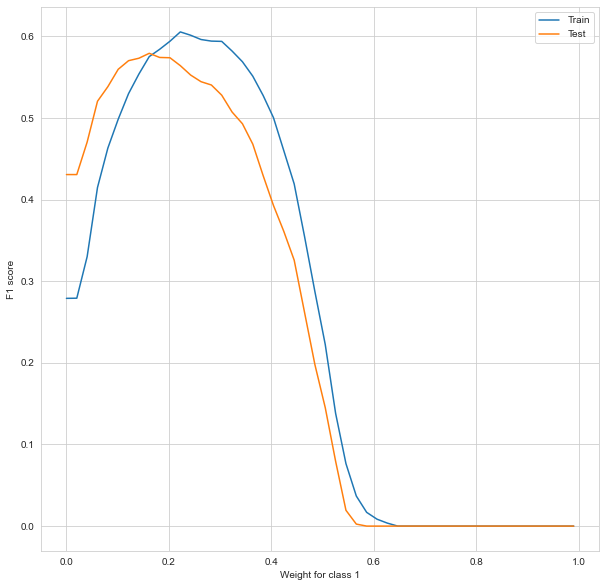

In [48]:
plt.figure(figsize=(10, 10))
plt.plot(weights, train_scores, label='Train')
plt.plot(weights, test_scores, label='Test')
plt.legend()
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.show()

In [76]:
LEN_OF_TRAIN_TWEETS = [len(i) for i in X_train]
NUM_TRAIN_WORDS = sum(LEN_OF_TRAIN_TWEETS)
TRAIN_MAX_LEN = max(LEN_OF_TRAIN_TWEETS)

LEN_OF_TEST_TWEETS = [len(i) for i in X_test]
NUM_TEST_WORDS = sum(LEN_OF_TEST_TWEETS)
TEST_MAX_LEN = max(LEN_OF_TEST_TWEETS)

In [77]:
train_tokenizer = Tokenizer(nb_words = NUM_TRAIN_WORDS)
train_tokenizer.fit_on_texts(X_train)
train_seq = train_tokenizer.texts_to_sequences(X_train)

test_tokenizer = Tokenizer(nb_words = NUM_TEST_WORDS)
test_tokenizer.fit_on_texts(X_test)
test_seq = test_tokenizer.texts_to_sequences(X_test)

c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [78]:
X_train_padding = pad_sequences(train_seq, maxlen=TRAIN_MAX_LEN, padding='post')
X_test_padding = pad_sequences(test_seq, maxlen=TEST_MAX_LEN, padding='post')

In [79]:
print(X_train_padding.shape)
print(X_test_padding.shape)

(10163, 116)
(2980, 238)


# Other

In [ ]:
def extract_emojis(tweet):
    return list(emojis.get(tweet))

In [ ]:
def contain_emoji(tweet):
    emo_list = list(emojis.get(tweet))
    if emo_list == list():
        return False
    else:
        return True

In [ ]:
df['emoji'] = df['tweet'].apply(extract_emojis)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[]
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]"
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[]
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[]
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[]


In [ ]:
df['contain_emoji'] = df['tweet'].apply(contain_emoji)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji,contain_emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[],False
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]",True
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[],False
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[],False
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[],False
